## 빅데이터 활용 AI 설계
# CGAN : Conditional GAN

In [2]:
! mkdir cgan_images

mkdir: cannot create directory ‘cgan_images’: File exists


In [1]:
! ls

cgan_images  gan_mnist.h5  sample_data


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

X_train.shape

(60000, 28, 28)

In [44]:
X_train = X_train/255
X_train = X_train[:,:,:,np.newaxis]

X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [45]:
y_train.shape

(60000,)

### Descriminator 정의

In [0]:
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Concatenate, Conv2D, \
        LeakyReLU, Flatten, Dropout, Dense, Conv2DTranspose
from keras.optimizers import Adam, RMSprop

In [47]:
in_label = Input((1,))
x_label = Embedding(10, 50)(in_label)
x_label = Dense(28*28)(x_label)
x_label = Reshape((28,28,1))(x_label) # 0~9 의 레이블을 받아들여서 28*28 인 채널을 하나 생성함

in_image = Input((28,28,1))

x = Concatenate()([in_image, x_label]) # 흑백이미지는 채널이 1, 레이블 채널을 추가해서 채널이 2가 됨

x # (?, 28, 28, 2)

<tf.Tensor 'concatenate_7/concat:0' shape=(?, 28, 28, 2) dtype=float32>

In [48]:
x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)

output = Dense(1, activation='sigmoid')(x)

discriminator = Model([in_image, in_label], output)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

discriminator.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        500         input_13[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1, 784)       39984       embedding_7[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
___________________________________________________________________________________________

### Generator 정의

In [49]:
in_label = Input((1,))
x_label = Embedding(10, 50)(in_label)
x_label = Dense(7*7)(x_label)
x_label = Reshape((7,7,1))(x_label) # 0~9 의 레이블을 받아들여서 7*7 인 채널을 하나 생성함

in_latent = Input((100,))
x_latent = Dense(7*7*128)(in_latent)
x_latent = LeakyReLU(alpha=0.2)(x_latent)
x_latent = Reshape((7,7,128))(x_latent)

x = Concatenate()([x_latent, x_label]) # (7,7,128) 생성 이미지층과 (7,7,1) 레이블 층을 결합

x # (?, 7, 7, 129)

<tf.Tensor 'concatenate_8/concat:0' shape=(?, 7, 7, 129) dtype=float32>

In [0]:
x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

output = Conv2D(1, (7,7), activation='sigmoid', padding='same')(x)  # why tanh not sigmoid?

generator = Model([in_latent, in_label], output)

In [51]:
generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 6272)         633472      input_16[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        500         input_15[0][0]                   
___________________________________________________________________________________________

### Adversarial 정의

In [52]:
discriminator.trainable = False

#adversarial = Model([in_latent, in_label], discriminator([generator([in_latent, in_label]), in_label])
adversarial = Model([in_latent, in_label], discriminator([output, in_label]))
adversarial.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 6272)         633472      input_16[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        500         input_15[0][0]                   
___________________________________________________________________________________________

In [0]:
adversarial.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0004, beta_1=0.5), metrics=['acc'])

### 훈련

In [54]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(10000):
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    real_labels = y_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    gen_labels = np.random.randint(10, size=batch_size)
    fake_images = generator.predict([gen_vectors, gen_labels])
    
    X = np.r_[real_images, fake_images] # [batch_size*2,28,28,1]
    y_label = np.r_[real_labels, gen_labels] # (batch_size*2,)
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch([X,y_label], y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    gen_labels2 = np.random.randint(10, size=(batch_size,1))
    ###########
    a_loss, a_acc = adversarial.train_on_batch([gen_vectors_2, gen_labels2], np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('cgan_images/fake_%05d.png' % (step+1))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001,  [0.6917231, 0.546875, 0.71575445, 0.03125]
Step: 00002,  [0.6758586, 0.890625, 0.74568474, 0.0]
Step: 00003,  [0.66201866, 0.9375, 0.77700907, 0.0]
Step: 00004,  [0.64939606, 0.875, 0.8065647, 0.0]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00005,  [0.6365582, 0.8828125, 0.8386301, 0.0]
Step: 00006,  [0.6287943, 0.8671875, 0.8576765, 0.0]
Step: 00007,  [0.61870027, 0.9140625, 0.8635787, 0.0]
Step: 00008,  [0.6240552, 0.8984375, 0.8482486, 0.0]
Step: 00009,  [0.629835, 0.9453125, 0.8111636, 0.0]
Step: 00010,  [0.63791823, 0.96875, 0.7676766, 0.0]
Step: 00011,  [0.64874196, 0.96875, 0.73296154, 0.0]
Step: 00012,  [0.6462507, 0.9921875, 0.70948815, 0.0]
Step: 00013,  [0.64123434, 0.8515625, 0.6979751, 0.125]
Step: 00014,  [0.6311754, 0.625, 0.6925144, 0.59375]
Step: 00015,  [0.6216457, 0.515625, 0.69082844, 0.765625]
Step: 00016,  [0.60849047, 0.5234375, 0.6905854, 0.890625]
Step: 00017,  [0.5911058, 0.546875, 0.69142246, 0.765625]
Step: 00018,  [0.5843564, 0.5703125, 0.6931139, 0.53125]
Step: 00019,  [0.5661957, 0.7109375, 0.6950099, 0.15625]
Step: 00020,  [0.55144936, 0.8125, 0.6968988, 0.03125]
Step: 00021,  [0.5255791, 0.984375, 0.699196, 0.0]
Step: 00022,  [0.5256702, 1.0, 0.7017555, 0.0]
Step: 00023,  [0.495608, 

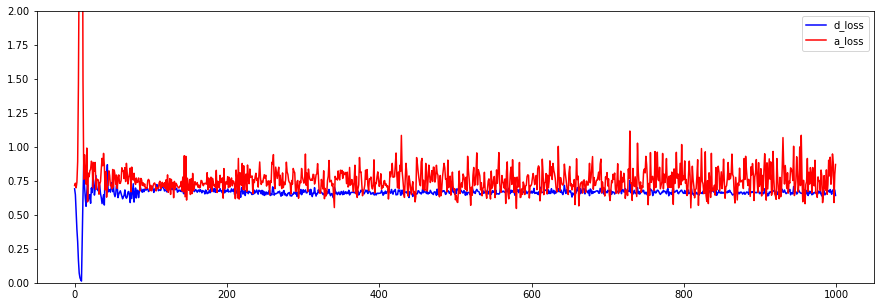

In [61]:
plt.figure(figsize=[15,5])
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.ylim(0,2)
plt.legend()

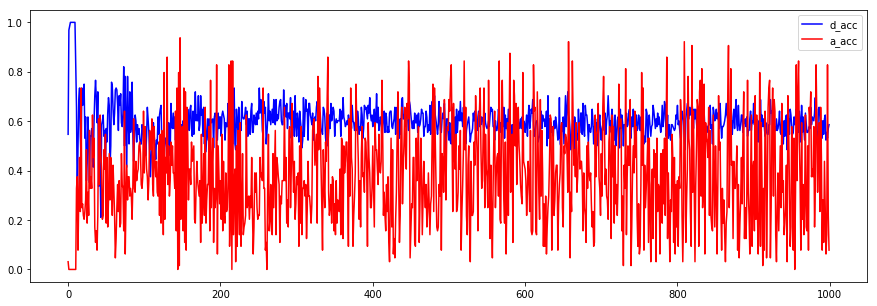

In [60]:
plt.figure(figsize=[15,5])
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

n = 1000


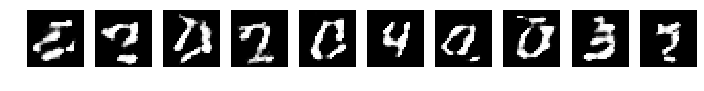

n = 2000


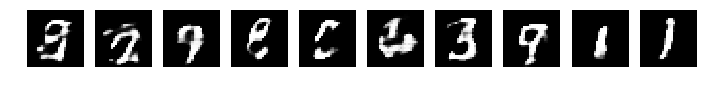

n = 3000


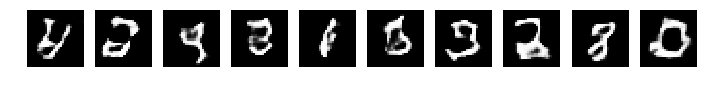

n = 4000


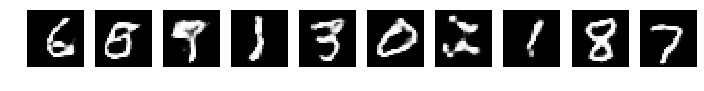

n = 5000


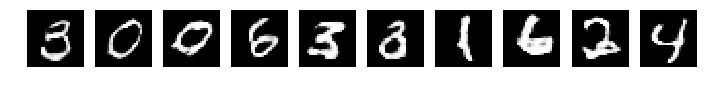

n = 6000


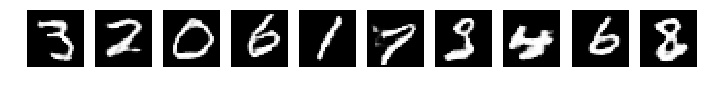

n = 7000


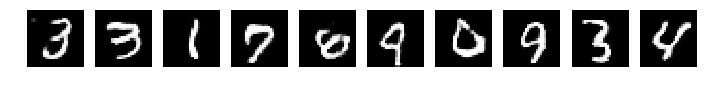

n = 8000


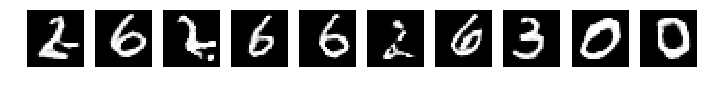

n = 9000


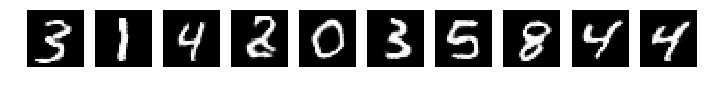

In [62]:
for n in range(1000, 10000, 1000):
  print('n =',n)
  plt.figure(figsize=[12,10])
  
  for i in range(10):
    plt.subplot(1,10,i+1)
    img = plt.imread('cgan_images/fake_%05d.png' %(n+10*i))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
   
  plt.show()

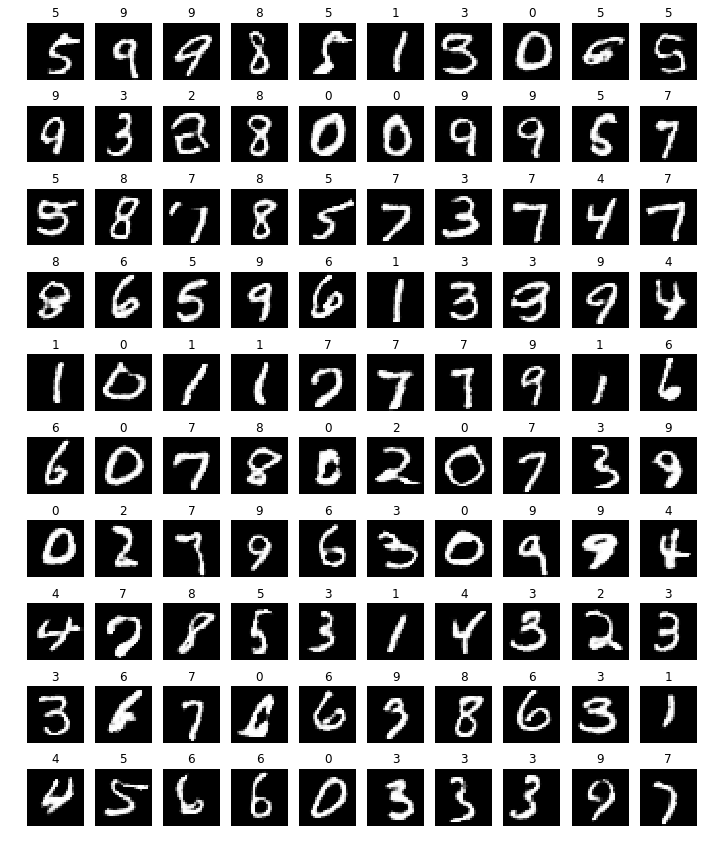

In [68]:
vectors = np.random.uniform(-1, 1, size=[100,100])
gen_labels = np.random.randint(10, size=100)
images = generator.predict([vectors, gen_labels])

plt.figure(figsize=[12,15])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(gen_labels[i])